In [1]:
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from torchvision.transforms import Compose
from torch.utils.data import Subset
from albumentations.pytorch import ToTensorV2

from typing import *


import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import albumentations as A
import torchvision.transforms as ts


ROOT_TRAIN = "data/train"
ROOT_VAL = "data/val"

In [2]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение различных моделей было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

<h4>ML Project 2. Image classification</h4>


<h4>School of Quants. ML2 project. Tiny Image classification</h4>

<a href="https://github.com/B0R0koko/TinyImageClassification200_SoQ_ML2">Github repo</a>


<p>In this project we trained EfficientNet model for image classification (Tiny Image Dataset)</p>
<br/>
<table>
  <tr>
    <th>Index</th>
    <th>Model</th>
  </tr>
  <tr>
    <td>EfficientNetb4_64x64_locally_trained</td>
    <td>0.405</td>
  </tr>
  <tr>
    <td>EfficientNetb4_224x224_ImageNet_pretrained_tuned</td>
    <td>0.755</td>
  </tr>
</table>
<br/>
<ul>
    <li>As the first part, we trained untrained EfficientNet model from scratch and get the accuracy on validation of 0.404. Grade - 9.02 / 10</li>
    <li>As a second part of the task, we trained a pretrained EfficientNet model on Imagenet 1k dataset, we added the last layer to make the last dense layer output 200 values which matches the number of labels in the dataset. With this, we were able to achieve 0.755 accuracy on validation set, which is shy of the target 0.84, but still good enough. Grade 7.53 / 10</li>
</ul>

<p>Unpack zipped data file into data folder with train and val folders. Also in the log folder we have log files which tracked the progress of the training and validation. We used Tensorboard for tracking.</p>

<br/>

<img src="./imgs/image.png" alt="Tensorboard. Model 1" width="500">

<h4>Task 1</h4>

In [3]:
# create dataloaders for train and val

train_transform = Compose([
    ts.RandomRotation(degrees=20),
    ts.RandomHorizontalFlip(p=0.2),
    ts.ToTensor(),
    ts.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

val_transform = Compose([
    ts.ToTensor(),
    ts.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


train_dataset = ImageFolder(ROOT_TRAIN, transform=train_transform)
val_dataset = ImageFolder(ROOT_VAL, transform=val_transform)

train_dataloader = DataLoader(dataset=train_dataset, pin_memory=True, batch_size=128, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, pin_memory=True, batch_size=128, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


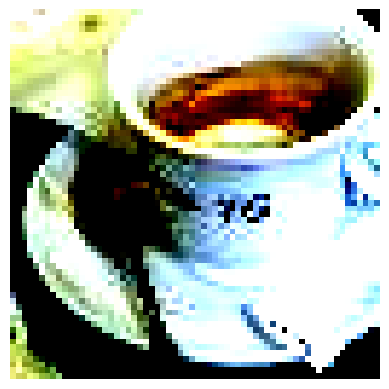

In [4]:
# show a couple of pictures
for image, label in val_dataloader:

    image = image[0].squeeze()
    
    # Transpose the dimensions to match the standard image dimensions (64, 64, 3)
    image = np.transpose(image, (1, 2, 0))

    plt.imshow(image)
    plt.axis('off')
    plt.show()
    break

<h4>Create Model and Trainer class</h4>

<p>Here we are training EfficientNet_b4 model. I tried almost all architectures listed on Pytorch website and also attempted to apply multiple different transformations
but still failed to reach the target of 0.44 accuracy, but we were able to get very close to it with the max validation score of 0.405</p>

<p>Class structure and code snippets were taken from another course I am taking at university</p>

<a href="https://github.com/fintech-dl-hse/course">Github of the course</a>

In [5]:
from abc import ABC, abstractmethod
from torch import Tensor
from torchvision.models import efficientnet_b4

class Model(ABC):

    @abstractmethod
    def compute_batch(self, X_batch: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
        """forward batch and compute evaluation metrics"""


class MyNet(Model, nn.Module):

    def __init__(self, *args, **kwargs) -> Self:
        super().__init__(*args, **kwargs)
        self.model = efficientnet_b4(weights=None, num_classes=200)
        
    def forward(self, x):
        return self.model(x)
    
    def compute_batch(self, X_batch: Tensor, label: Tensor) -> Tuple[torch.Tensor, float]:
        
        logits: torch.Tensor = self.forward(X_batch)
        loss: torch.Tensor = F.cross_entropy(logits, label)
        # compare to ground truth
        accuracy: np.array[bool] = (logits.argmax(axis=1) == label).float().mean().cpu().numpy()

        return loss, accuracy

In [6]:
# define trainer class for training and validation of the model
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter


class Trainer:
    def __init__(
        self, model: Model, optimizer, train_loader: DataLoader, 
        val_loader: DataLoader, log_dir="log"
    ) -> Self:
        
        self.model: Model = model
        self.optimizer = optimizer
        self.device: str = torch.cuda.current_device() if torch.cuda.is_available() else "cpu"
        # Train model on CUDA device or CPU
        self.model = self.model.to(self.device)

        # Create dataloaders for train and validation splits
        self.train_loader: DataLoader = train_loader
        self.val_loader: DataLoader = val_loader

        # Log training process to Tensorboard
        self.logger: SummaryWriter = SummaryWriter(log_dir=log_dir)
        self.global_step: int = 0


    def train_one_epoch(self) -> None:
        # Set model into train mode 
        self.model.train()

        X_batch: torch.Tensor
        label: torch.Tensor

        train_accuracies: List[float] = []

        # Iterating over batches
        for X_batch, label in tqdm(self.train_loader):
            X_batch = X_batch.to(self.device) 
            label = label.to(self.device)

            train_loss: torch.Tensor
            train_accuracy: float
            train_loss, train_accuracy = self.model.compute_batch(X_batch=X_batch, label=label)
            train_accuracies.append(train_accuracy)

            self.optimizer.zero_grad()
            train_loss.backward()
            self.optimizer.step()

        # Take average train_accuracy across batches
        train_accuracy = np.mean(train_accuracies)
        self.logger.add_scalar(tag="train_accuracy", scalar_value=train_accuracy, global_step=self.global_step)

        val_accuracies: List[float] = []
        # Iterate over val data
        with torch.no_grad():
            self.model.eval()

            for X_batch, label in tqdm(self.val_loader):
                X_batch = X_batch.to(self.device) 
                label = label.to(self.device)

                val_loss: torch.Tensor
                val_accuracy: float
                val_loss, val_accuracy = self.model.compute_batch(X_batch=X_batch, label=label)
                val_accuracies.append(val_accuracy)

        val_accuracy = np.mean(val_accuracies)
        self.logger.add_scalar(tag="val_accuracy", scalar_value=val_accuracy, global_step=self.global_step)

        self.global_step += 1


    def train(self, num_epochs: int) -> None:
        for epoch in range(num_epochs):
            self.train_one_epoch()

<h4>Start training process</h4>

In [7]:
# load trained model (my own checkpoint)
model = MyNet()
model.load_state_dict(torch.load("trained_models/model_task1.pt"))

<All keys matched successfully>

In [ ]:
model = MyNet()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

trainer = Trainer(
    model=model, optimizer=optimizer, train_loader=train_dataloader, val_loader=val_dataloader,
    log_dir="log/log_model1"
)

trainer.train(num_epochs=10)

In [8]:
# Here I use the code snippet provided in the file to evaluate the model and grade it
def evaluate_task(model: Model, val_dataloader: DataLoader, device="cuda:0"):
    model = model.to(device)
    model.eval()

    val_accuracies = []

    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits: torch.Tensor = model.forward(images)
            # compare to ground truth
            accuracy: np.array[bool] = (logits.argmax(axis=1) == labels).float().mean().cpu().numpy()
            val_accuracies.append(accuracy)
    
    return np.mean(val_accuracies)

In [9]:
val_accuracy: float = evaluate_task(model=model, val_dataloader=val_dataloader)

print(f"Оценка за это задание составит {np.clip(10 * val_accuracy / 0.44, 0, 10):.2f} баллов")

100%|██████████| 79/79 [00:06<00:00, 12.27it/s]

Оценка за это задание составит 9.02 баллов


In [ ]:
# save the model
os.makedirs("trained_models", exist_ok=True)

torch.save(model.state_dict(), "trained_models/model_task1.pt")

<h4>Task 2. Reach 0.84 accuracy on val set</h4>

<p>We will perform transfer learning, we will use EfficientNet b4 pretrained on 1k Imagenet dataset, we will slightly adjust the last layer to match 200 labels in this dataset</p>

In [10]:
train_transform = ts.Compose([
    ts.Resize(size=(224, 224)),
    ts.RandomRotation(20),
    ts.RandomHorizontalFlip(0.5),
    ts.ToTensor(),
    ts.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
])

val_transform = ts.Compose([
    ts.Resize(size=(224, 224)),
    ts.ToTensor(),
    ts.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
])


train_dataset = ImageFolder(ROOT_TRAIN, transform=train_transform)
val_dataset = ImageFolder(ROOT_VAL, transform=val_transform)

train_dataloader = DataLoader(
    dataset=train_dataset, pin_memory=True, batch_size=32, shuffle=True
)
val_dataloader = DataLoader(
    dataset=val_dataset, pin_memory=True, batch_size=32, shuffle=True
)

<h4>Transfer learning + Resizing</h4>

<p>Use weights of the pretrained model and modify the last layer to match output size</p>

In [11]:
from torchvision.models import swin_v2_b, Swin_V2_B_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import EfficientNet_B4_Weights, efficientnet_b4


class MyNet2(Model, nn.Module):

    def __init__(self, *args, **kwargs) -> Self:
        super().__init__(*args, **kwargs)

        self.inner = nn.Sequential(
            efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1),
            nn.Linear(1000, 200)
        )
        
    def forward(self, x):
        return self.inner(x)
    
    def compute_batch(self, X_batch: Tensor, label: Tensor) -> Tuple[torch.Tensor, float]:
        
        logits: torch.Tensor = self.forward(X_batch)
        loss: torch.Tensor = F.cross_entropy(logits, label)
        # compare to ground truth
        accuracy: np.array[bool] = (logits.argmax(axis=1) == label).float().mean().cpu().numpy()

        return loss, accuracy

In [ ]:
model2 = MyNet2()

optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

trainer = Trainer(
    model=model2, optimizer=optimizer, train_loader=train_dataloader, val_loader=val_dataloader, log_dir="log/log_model_2"
)

trainer.train(num_epochs=10)

In [ ]:
os.makedirs("trained_models", exist_ok=True)

torch.save(model2.state_dict(), "trained_models/model_task2.pt")

In [14]:
model2 = MyNet2()
model2.load_state_dict(torch.load("trained_models/model_task2.pt"))

<All keys matched successfully>

In [15]:
accuracy = evaluate_task(model2, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

100%|██████████| 313/313 [00:23<00:00, 13.47it/s]

Оценка за это задание составит 7.53 баллов
